# Catboost Modeling and Tuning
## Summary
In this notebook I will primarily address the class imbalance in the dataset. I'll explore the following techinques and explore how they affect the Catboost model:
- Class weights
- Random over sampling
- SMOTE

After checking each of them I'll select one that I feel best addresses the issue.

# Modeling

In [2]:
# Import statements
import pandas as pd
from catboost import CatBoostClassifier, metrics

# Importing module for creating confusion matrices.
from sklearn.metrics import ConfusionMatrixDisplay

from imblearn.over_sampling import RandomOverSampler, SMOTEN

# Created functions from functions.py
from functions import metrics as custom_score
from functions import improvement as custom_change

In [3]:
# Load in cleaned data

# Training Data
X_train = pd.read_csv('../Data/train/X_train.csv', index_col=0)
y_train = pd.read_csv('../Data/train/y_train.csv', index_col=0)

# Testing Data
X_test = pd.read_csv('../Data/test/X_test.csv', index_col=0)
y_test = pd.read_csv('../Data/test/y_test.csv', index_col=0)

In [4]:
# Currently the classes are labelled as "1" as dignosed ADHD and "2" as not diagnosed, but models seem to dislike this.
testing = {2: 0, 1: 1}
# Using sklearn LabelBinarizer to change classes to "0" and "1" so that Keras doesn't get confused.
labels = y_train.replace(testing)
test_labels = y_test.replace(testing)

# This cell will be moved into the "Data cleaning" notebook in the future.

## Base Catboost model
Without changing anything, lets make the base catboost model again to use as a starting point.

In [5]:
# Setting up the model
base = CatBoostClassifier(
    # Adding Accuracy as a metric
    custom_loss=[metrics.Accuracy()],
    random_seed=15,
    logging_level='Silent'
)

base.fit(
    X_train, labels,
    # Using X/y test as eval set
    eval_set=(X_test, test_labels),
    # Uncomment below line to plot the learning of the model
    # plot=True
);

In [6]:
# Results on test set
base_results = custom_score(test_labels, base.predict(X_test))

Model Results
Accuracy: 0.93
Precision: 0.74
Recall: 0.56
F1: 0.63
ROC AUC: 0.77


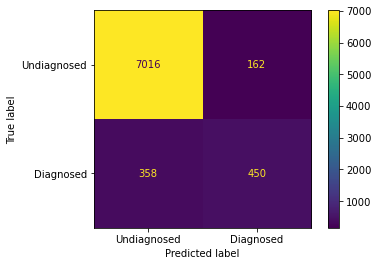

In [7]:
# Creating a confusion matrix for the base model
base_matrix = ConfusionMatrixDisplay.from_predictions(test_labels, base.predict(X_test), display_labels=['Undiagnosed','Diagnosed' ])

## Analysis
This is a good start, but the model is still having a lot of trouble with the class imbalance.

The model has a precision of 0.74 —in other words, **when it predicts a child is diagnosed with ADHD, it is correct 74% of the time**.

Our model has a recall of 0.56—in other words, **it correctly identifies 56% of all children with ADHD**.

The recall score, in paticular needs to be improved. The class imbalance needs to be addressed before tuning. Some options:
   - Class weights
   - Over/Undersampling
   - SMOTE (Make more samples)

Catboost does support class weights, so that will be first since it is the simplest to implement.

## Class Weights

In [8]:
# Setting up the model
weighted_cat = CatBoostClassifier(
    # Adding Accuracy as a metric
    custom_loss=[metrics.Accuracy(), metrics.Recall(), metrics.Precision()],
    random_seed=15,
    logging_level='Silent',
    # Setting class weights to 'balanced'
    auto_class_weights='Balanced'
)

weighted_cat.fit(
    X_train, labels,
    # Using X/y test as eval set
    eval_set=(X_test, test_labels),
    # Uncomment below line to plot the learning of the model
    # plot=True
);

In [9]:
# Results on test set
weighted_results = custom_score(test_labels, weighted_cat.predict(X_test))

Model Results
Accuracy: 0.89
Precision: 0.49
Recall: 0.84
F1: 0.62
ROC AUC: 0.87


In [10]:
# Printing changes between base model and weighted model
custom_change(base_results, weighted_results)

Change in Results
Accuracy        -0.04
Precision       -0.25
Recall          +0.29
F1              -0.02
ROCAUC          +0.10


## Analysis
Adding the weights flipped our model around, now precision has dropped, and recall has improved significantly. For this project, I'd prefer recall over precision. I don't want the model to be missing kids that may have, potentially, already been ignored by doctors. I think the gain in recall and ROC/AUC is well worth the loss of precision, but let's see if one of the other methods works better.

## Random Oversampling
I'm going to use the [imbalanced-learn](https://imbalanced-learn.org/stable/index.html) library to perform oversampling/ SMOTE techinques.

In [11]:
# Initiate Over sampler
ros = RandomOverSampler(random_state=15)

# Applying ONLY to training set to prevent data leakage.
X_train_os, y_train_os = ros.fit_resample(X_train, labels)

In [12]:
# Setting up the model
over_cat = CatBoostClassifier(
    # Adding Accuracy as a metric
    custom_loss=[metrics.Accuracy(), metrics.Recall(), metrics.Precision()],
    random_seed=15,
    logging_level='Silent',
)

over_cat.fit(
    X_train_os, y_train_os,
    # Using X/y test as eval set
    eval_set=(X_test, test_labels),
    # Uncomment below line to plot the learning of the model
    # plot=True
);

In [13]:
# Printing results on test set
os_results = custom_score(test_labels, over_cat.predict(X_test))

Model Results
Accuracy: 0.92
Precision: 0.60
Recall: 0.71
F1: 0.65
ROC AUC: 0.83


In [14]:
# Printing the difference between BASE and os_results
print('Difference between Base model and model with oversampling ')
custom_change(base_results, os_results)

Difference between Base model and model with oversampling 
Change in Results
Accuracy        -0.01
Precision       -0.13
Recall          +0.15
F1              +0.02
ROCAUC          +0.06


In [15]:
print('Difference between Weighted model and model with oversampling ')
custom_change(weighted_results, os_results)

Difference between Weighted model and model with oversampling 
Change in Results
Accuracy        +0.03
Precision       +0.12
Recall          -0.14
F1              +0.03
ROCAUC          -0.04


## Analysis
This model seems to be a "middle ground" between the weighted model and the base model. Rather then having really high accuracy or precision, it has a decent score on both, and still manages to maintain a high ROC/AUC score. There is one more technique I'll try before sticking with one of these.

# SMOTEN
I'll be using SMOTEN since it is designed specifically for categorical data.

In [16]:
# Create SMOTE object
smote = SMOTEN(random_state=15)

# Smite that training data
X_smote, y_smote = smote.fit_resample(X_train, labels)

In [24]:
# Setting up the model
smote_cat = CatBoostClassifier(
    custom_loss=[metrics.Accuracy(), metrics.Recall(), metrics.Precision()],
    random_seed=15,
    logging_level='Silent',
)

smote_cat.fit(
    X_smote, y_smote,
    # Using X/y test as eval set
    eval_set=(X_test, test_labels),
    # Uncomment below line to plot the learning of the model
    # plot=True
);

In [25]:
# Printing results on test set
smote_results = custom_score(test_labels, smote_cat.predict(X_test))

Model Results
Accuracy: 0.93
Precision: 0.70
Recall: 0.57
F1: 0.63
ROC AUC: 0.77


In [26]:
# Compare to Oversampling results
custom_change(os_results, smote_results)

Change in Results
Accuracy        +0.01
Precision       +0.09
Recall          -0.14
F1              -0.03
ROCAUC          -0.06


## Analysis
Smote performs slightly worse then both of the other options, in almost every way. Survey data does not seem to work well with SMOTE.

# Conclusion
After checking the three suggested methods: Class weights, oversampling, and SMOTE I think theres a clear winner here. I'm going to use **Random Over Sampling** since it gave the most balanced results. I could try playing with the class weights a bit more, but I think it would require a lot more time, and probably won't result in an equally large increase to performance. Now, I'll perform oversampling and start the process of tuning the model.